Includes

In [251]:
using SparseArrays, LinearAlgebra, Arpack, Plots, LsqFit, RandomMatrix, TensorOperations

Auxilary functions

In [252]:
function random_ψ(L)
    ψ=rand(2^L)
    ψ./=norm(ψ)
    return ψ
end;

From Recitations

In [253]:
function NormalizePsi!(psi::Vector{Array{Float64}})
    """
    NormalizePsi!(psi::Vector{Array{Float64}})

    Normalize and bring the orthogonality center to the first site in a Matrix Product State (MPS), assuming right canonical form.

    # Arguments
    - `psi`: Array of matrices representing the MPS.

    """
    L = length(psi)

    # Iterate from the last site to the second site
    for i in L-1:-1:1
        # Calculate the bond tensor between current site i and i+1
        psi_bond = BondTensor(psi, i)

        # Orthogonally update the MPS using the Singular Value Decomposition (SVD), assuming right canonical form
        SvdBondTensor!(psi, i, psi_bond, false, -1, true)
        # ortho_left = false => Update the matrix at site i+1 (right canonical form)
        # maxM = -1 => No truncation
        # renorm = true => Renormalize the singular values
    end
end;

In [311]:
function SvN(psi, l)
    # Von Neumann entropy calculation to subsystems of size l and L-l From Recitation
    D = size(psi)[1]
    logD = log2(D)
    @assert isinteger(logD) "State vector of incompatible length"
    L = Int(logD) # How many qubits in the state?
    @assert l>0 && l<L "Invalid bipartition", L
    
    dims_tuple=(2^l,2^(L-l))
    psi_matrix = reshape(psi, dims_tuple)
    U,s,V = svd(psi_matrix)
    s = s[s .> 1e-14] # choosing non-zero singular values
    w = s.^2
    return -sum(w.*log.(w))
end;

In [255]:
function PolarizedMPS(L::Int64)
    # Initialize an array to store matrices representing the polarized state MPS.
    psi = Array{Float64}[]

    # Iterate through each site in the 1D quantum system.
    for i in 1:L
        # For each site, add a matrix with coefficients [1.0, 0.0] to the array.
        push!(psi, reshape([1.0, 0.0], (1, 2, 1)))
    end

    # Return the array representing the polarized state MPS.
    return psi
end

function NeelMPS(L::Int64)
    # Initialize an array to store matrices representing the Neel state MPS.
    psi = Array{Float64}[]

    # Iterate through each site in the 1D quantum system.
    for i in 1:L
        # Check if the site index is odd (spin-up) or even (spin-down).
        if isodd(i)
            # For spin-up, add a matrix with coefficients [1.0, 0.0] to the array.
            push!(psi, reshape([1.0, 0.0], (1, 2, 1)))
        else
            # For spin-down, add a matrix with coefficients [0.0, 1.0] to the array.
            push!(psi, reshape([0.0, 1.0], (1, 2, 1)))
        end
    end

    # Return the array representing the Neel state MPS.
    return psi
end;

In [256]:
function MPSrep_LC(psi::Vector{Float64}, maxM=0)
    """
    MPSrep_LC(psi::Vector{Float64}, maxM=0)

    Convert a state vector into a Matrix Product State (MPS) representation using singular value decomposition (SVD).

    # Arguments
    - `psi`: The state vector to be converted into MPS.
    - `maxM`: The maximum number of singular values to keep in each step. If 0, no truncation is performed.

    # Returns
    - `psi_mps`: Array of matrices representing the MPS.
    - `VN`: Array of von Neumann entropies at each step.
    - `Ms`: Array of the number of retained singular values at each step.
    - `Trunc`: Array of truncation errors at each step if maxM > 0 and truncation occurs.

    """
    D = size(psi)[1]
    logD = log2(D)
    @assert isinteger(logD) "State vector of incompatible length"
    L = Int(logD) # How many qubits in the state?
    psi_mps = []
    VN = []
    Ms = []
    Trunc = []

    psi_matrix = reshape(psi, (2, 2^(L-1)))

    for l in 1:L-1
        # Singular Value Decomposition (SVD)
        U, s, V = svd(psi_matrix)

        # Find the last non-zero singular value
        Ml = findlast(s .> 1e-14)

        # Retain only relevant parts of U, s, and V
        U, s, V = U[:, 1:Ml], s[1:Ml], V[:, 1:Ml]

        # Calculate von Neumann entropy
        w = s.^2
        svn = -sum(w .* log.(w))

        # If 0 < maxM < Ml - truncation, perform truncation
        if (maxM > 0 && Ml > maxM)
            trunc = sum(s[maxM:end].^2)
            push!(Trunc, trunc)
            U, s, V = U[:, 1:maxM], s[1:maxM], V[:, 1:maxM]
            s /= sqrt(1. - trunc)
            Ml = maxM
        end

        push!(Ms, Ml)
        push!(VN, svn)

        # Reshape U into the MPS format
        if (l == 1)
            push!(psi_mps, reshape(U, (1, 2, Ml)))
        else
            push!(psi_mps, reshape(U, (Ms[end-1], 2, Ml)))
        end

        # Reshape V into the MPS format for the next iteration
        if (l == L-1)
            push!(psi_mps, reshape(diagm(s) * V', (Ml, 2, 1)))
        else
            psi_matrix = reshape(diagm(s) * V', (2 * Ml, 2^(L-l-1)))
        end
    end

    return psi_mps, VN, Ms, Trunc
end;

In [941]:
function BondTensor(psi::Vector{Array{Float64}}, b::Int64)
    """
    BondTensor(psi::Vector{Array{Float64}}, b::Int64)

    Construct the bond tensor between two adjacent sites in a Matrix Product State (MPS).

    # Arguments
    - `psi`: Array of matrices representing the MPS.
    - `b`: Index of the bond between adjacent sites (1 to length(psi)-1).

    # Returns
    - `psi_bond`: Bond tensor connecting sites `b` and `b+1`.

    """
    @assert b >= 1 && b <= (length(psi)-1) "Bond out of range"

    # Dimensions of matrices at site b and site b+1
    M0 = size(psi[b])[1]
    M2 = size(psi[b+1])[3]

    M1 = size(psi[b])[2]
    
    # Initialize the bond tensor
    #psi_bond = zeros(M0, 2, 2, M2)
    psi_bond = zeros(M0, M1, M1, M2)

    # Contract matrices at site b and site b+1 to form the bond tensor
    @tensor psi_bond[l0, s1, s2, l2] = psi[b][l0, s1, l1] * psi[b+1][l1, s2, l2]

    return psi_bond
end;

In [955]:
function SvdBondTensor!(psi::Vector{Array{Float64}}, b::Int64, psi_bond::Array{Float64}, ortho_left=true, maxM=-1, renorm=false)
    """
    SvdBondTensor!(psi::Vector{Array{Float64}}, b::Int64, psi_bond::Array{Float64}, ortho_left=true, maxM=-1, renorm=false)

    Update the Matrix Product State (MPS) by performing a Singular Value Decomposition (SVD) on the bond tensor.

    # Arguments
    - `psi`: Array of matrices representing the MPS.
    - `b`: Index of the bond between adjacent sites (1 to length(psi)-1).
    - `psi_bond`: Bond tensor connecting sites `b` and `b+1`.
    - `ortho_left`: If true, orthogonally update the matrix at site `b` (left-canonical). If false, orthogonally update the matrix at site `b+1` (right-canonical).
    - `maxM`: The maximum number of singular values to keep in each step. If -1, no truncation is performed.
    - `renorm`: If true, renormalize the singular values after the SVD.

    # Returns
    - `trunc`: Truncation error if truncation occurs, otherwise 0.

    """
    @assert length(size(psi_bond)) == 4 "psi_bond is expected to be a rank-4 tensor"

    trunc = 0.

    M0 = size(psi_bond)[1]
    M2 = size(psi_bond)[4]
    
    M_physical = size(psi_bond)[2]

    # Reshape the bond tensor into a matrix for SVD
    psi_bond_matrix = reshape(psi_bond, (M0*M_physical, M2*M_physical))

    # Perform SVD on the reshaped bond tensor matrix
    U, S, V = svd(psi_bond_matrix)

    # Optionally renormalize the singular values
    if renorm
        S /= norm(S)
    end

    # Find the last non-zero singular value
    M1 = findlast(S .> 1e-16)

    # Retain only relevant parts of U, S, and V
    U, S, V = U[:, 1:M1], S[1:M1], V[:, 1:M1]

    # If 0 < maxM < M1 - truncation, perform truncation
    if maxM > 0 && M1 > maxM
        trunc = sum(S[maxM:end].^2)
        U, S, V = U[:, 1:maxM], S[1:maxM], V[:, 1:maxM]
        S /= sqrt(1. - trunc)
        M1 = maxM
    end

    # Update the MPS matrices based on the SVD results
    if ortho_left
        psi[b] = reshape(U, (M0, M_physical, M1))
        psi[b+1] = reshape(Diagonal(S) * V', (M1, M_physical, M2))
    else
        psi[b] = reshape(U * Diagonal(S), (M0, M_physical, M1))
        psi[b+1] = reshape(V', (M1, M_physical, M2))
    end

    return trunc
end;

In [496]:
function BondH(h1::Float64, h2::Float64)
    """
    BondH(h1::Float64, h2::Float64)

    Generate the bond Hamiltonian matrix for a two-site bond in the Transverse Field Ising Model (TFIM).

    # Arguments
    - `h1`: Coefficient for the Sx⨂Id term.
    - `h2`: Coefficient for the Id⨂Sx term.

    # Returns
    The Hamiltonian matrix for the two-site bond in the TFIM.

    """
    # Pauli matrices
    Sx = [0.0 1.0; 1.0 0.0]
    Sz = [1.0 0.0; 0.0 -1.0]
    Id = [1.0 0.0; 0.0 1.0]

    # Construct the Hamiltonian matrix for the two-site bond in the TFIM
    Hb = -kron(Sz, Sz) - h1 * kron(Sx, Id) - h2 * kron(Id, Sx)
    
    return Hb
end;

In [260]:
function GateTensor(dt::Float64, h1::Float64, h2::Float64)
    """
    GateTensor(dt::Float64, h1::Float64, h2::Float64)

    Generate the gate tensor for a time evolution step in the Transverse Field Ising Model (TFIM).

    # Arguments
    - `dt`: Time step for the evolution.
    - `h1`: Coefficient for the Sx⨂Id term.
    - `h2`: Coefficient for the Id⨂Sx term.

    # Returns
    The gate tensor for the time evolution step in the TFIM.

    """
    # Generate the Hamiltonian matrix for the two-site bond in the TFIM
    Hb = BondH(h1, h2)

    # Construct the gate tensor for the time evolution step using the Hamiltonian
    G = exp(-dt/2 * Hb)

    # Reshape the gate tensor to a 4-index tensor
    return reshape(G, (2, 2, 2, 2))
end;

In [261]:
function ApplyGate!(psi::Vector{Array{Float64}}, op::Array{Float64}, b::Int64, ortho_left=true, maxM=-1, renorm=false)
    """
    ApplyGate!(psi::Vector{Array{Float64}}, op::Array{Float64}, b::Int64, ortho_left=true, maxM=-1, renorm=false)

    Apply a gate to a specific bond in the Matrix Product State (MPS) representation.

    # Arguments
    - `psi`: Array of matrices representing the MPS.
    - `op`: Array representing the gate to be applied.
    - `b`: Index of the bond where the gate is applied.
    - `ortho_left`: If true, update the left canonical form after applying the gate. Default is true.
    - `maxM`: Maximum bond dimension. If -1, no truncation is performed. Default is -1.
    - `renorm`: If true, renormalize singular values after applying the gate. Default is false.

    # Returns
    The truncation error if truncation is performed.

    """
    trunc = 0.

    # Calculate the bond tensor for the current bond
    psi_bond = BondTensor(psi, b)

    # Initialize a new bond tensor after applying the gate
    new_psi_bond = zeros(size(psi_bond))
    
    # Contract the gate with the current bond tensor to obtain the new bond tensor
    @tensor new_psi_bond[l0, s1p, s2p, l2] = op[s2p, s1p, s2, s1] * psi_bond[l0, s1, s2, l2]

    # Update the MPS by applying the new bond tensor
    trunc = SvdBondTensor!(psi, b, new_psi_bond, ortho_left, maxM, renorm)

    return trunc
end;

In [685]:
function iTEBD_sweep!(psi::Vector{Array{Float64}}, dt::Float64, h::Float64, maxM::Int64)
    """
    iTEBD_sweep!(psi::Vector{Array{Float64}}, dt::Float64, h::Float64, maxM::Int64)

    Perform a single sweep of the imaginary time evolution using Time-Evolving Block Decimation (iTEBD).

    # Arguments
    - `psi`: Array of matrices representing the Matrix Product State (MPS).
    - `dt`: Time step for the evolution.
    - `h`: Transverse field strength.
    - `maxM`: Maximum bond dimension.

    # Returns
    The maximum truncation error during the sweep.

    """
    L = length(psi)
    
    maxTrunc = 0.

    # Sweep right
    for i in range(1, stop=L-1)
        h1 = i == 1 ? h : h / 2
        h2 = i == L-1 ? h : h / 2

        gateOp = GateTensor(dt, h1, h2)
        
        # Apply the gate, update orthogonality center to the right, and renormalize
        trunc = ApplyGate!(psi, gateOp, i, true, maxM, true)
        
        # Update the maximum truncation error
        if trunc > maxTrunc
            maxTrunc = trunc
        end
    end

    
    # Sweep left
    for i in range(L-1, stop=1, step=-1)
        h1 = i == 1 ? h : h / 2
        h2 = i == L-1 ? h : h / 2
    
        gateOp = GateTensor(dt, h1, h2)
        
        # Apply the gate, update orthogonality center to the left, and renormalize
        trunc = ApplyGate!(psi, gateOp, i, false, maxM, true)
        
        # Update the maximum truncation error
        if trunc > maxTrunc
            maxTrunc = trunc
        end
    end
    
    return maxTrunc
end;

In [644]:
function CalculateEnergy!(psi::Vector{Array{Float64}}, h::Float64)
    """
    CalculateEnergy!(psi::Vector{Array{Float64}}, h::Float64)

    Calculate the energy of the Matrix Product State (MPS) representation.

    # Arguments
    - `psi`: Array of matrices representing the MPS.
    - `h`: Transverse field strength.

    # Returns
    The total energy of the MPS.

    """
    L = length(psi)
    
    Etot = 0.

    for i in range(1, stop=L-1)
        h1 = i == 1 ? h : h / 2
        h2 = i == L-1 ? h : h / 2
        
        # Generate the Hamiltonian matrix for the two-site bond
        Hb = reshape(BondH(h1, h2), (2, 2, 2, 2))
        
        # Calculate the bond tensor for the current bond
        psi_bond = BondTensor(psi, i)
        
        # Initialize a tensor for H * psi
        H_psi = zeros(size(psi_bond))
        
        # Contract H with the current bond tensor to obtain H * psi
        @tensor H_psi[l0, s1p, s2p, l2] = Hb[s2p, s1p, s2, s1] * psi_bond[l0, s1, s2, l2]
        
        # Contract psi^† * H * psi to obtain the energy contribution
        @tensor psi_H_psi = psi_bond[l0, s1p, s2p, l2] * H_psi[l0, s1p, s2p, l2]
        
        # Accumulate the energy contribution
        Etot += psi_H_psi
        
        # Update the MPS by applying the new bond tensor with left canonical form (no truncation or renormalization)
        SvdBondTensor!(psi, i, psi_bond, true)
    end
    
    return Etot
end;

In [415]:
mutable struct MPSrep
    oc::Int64                        # orthogonality center
    maxM::Int64                      # maximal bond dimension
    state::Vector{Array{Float64}}  
    
    function MPSrep(psi::Vector{Float64}, maxM=-1)
        # initial MPS given in left-canonical form, oc at rightmost site
        state, VN, Ms, Trunc = MPSrep_LC(psi, maxM)
        oc = length(state)
        new(oc, maxM, state)
    end
    
    function MPSrep(psi::Vector{Array{Float64}})
        # initial MPS given in right-canonical form, oc at leftmost site
        oc = 1
        maxM = -1
        state = deepcopy(psi)
        new(oc, maxM, state)
    end
    
end;

In [747]:
function CorrelationsByLength(psi_mps::MPSrep, Op)
    """
    CorrelationsByLength(psi_mps::MPSrep, Op)

    Calculate correlations by length for an operator (Op) in a Matrix Product State (MPS).

    # Arguments
    - `psi_mps`: An object representing the MPS.
    - `Op`: The operator for which to calculate the correlations.

    # Returns
    An array of correlation values for each site.

    """
    i0 = 1
    Corr = []

    # Move the orthogonality center to the first site
    OrthogonalizePsi!(psi_mps, i0)
    Ai0 = psi_mps.state[i0]
    M0 = size(Ai0)[1]
    M1 = size(Ai0)[3]

    # Initialize tensors for Ai * Op
    Ai_Sop = zeros(M0, 2, M1)
    @tensor Ai_Sop[l0, sp, l1] = Ai0[l0, s, l1] * Op[s, sp]

    # Calculate Ai * Op * Ai'
    AiAip = zeros(M1, M1)
    @tensor AiAip[l1, l1p] = Ai_Sop[l0, sp, l1] * Ai0[l0, sp, l1p]

    for j0 in 2:L
        # Iterate from i0+1 to j0-1
        for k in i0+1:j0-1
            Ak = psi_mps.state[k]
            M2 = size(Ak)[3]

            # Initialize tensors for AiAip * Ak
            AiAip_Ak = zeros(M1, 2, M2)
            @tensor AiAip_Ak[l1p, s, l2] = AiAip[l1, l1p] * Ak[l1, s, l2]

            # Calculate AiAip * Ak * AiAip'
            AiAip = zeros(M2, M2)
            @tensor AiAip[l2, l2p] = AiAip_Ak[l1p, s, l2] * Ak[l1p, s, l2p]

            # Update M1 for the next iteration
            M1 = M2
        end

        Aj0 = psi_mps.state[j0]
        M2 = size(Aj0)[3]

        # Initialize tensors for AiAip * Ak * Op
        AiAip_Ak = zeros(M1, 2, M2)
        @tensor AiAip_Ak[l1p, s, l2] = AiAip[l1, l1p] * Aj0[l1, s, l2]
        AiAip_Ak_Op = zeros(M1, 2, M2)
        @tensor AiAip_Ak_Op[l1p, sp, l2] = AiAip_Ak[l1p, s, l2] * Op[s, sp]

        # Calculate AiAip * Ak * Op * Aj0'
        @tensor Val = AiAip_Ak_Op[l1p, sp, l2] * Aj0[l1p, sp, l2]

        # Store the correlation value
        push!(Corr, Val)
    end

    return Corr
end;

In [266]:
function OrthogonalizePsi!(psi_mps::MPSrep, i0::Int64)
    """
    OrthogonalizePsi!(psi_mps::MPSrep, i0::Int64)

    Bring the orthogonality center to site i0 in a Matrix Product State (MPS), updating the MPS representation.

    # Arguments
    - `psi_mps`: An object representing the MPS.
    - `i0`: The target site to which the orthogonality center (oc) should be moved.

    """
    L = length(psi_mps.state)
    oc = psi_mps.oc

    if i0 > oc
        # Move the orthogonality center to the right: Add more left canonical forms
        for i in oc:i0-1
            psi_bond = BondTensor(psi_mps.state, i)
            # ortho_left = true => Update the matrix at site i (left canonical form)
            # maxM = -1 => No truncation
            # renormalize = false => Do not renormalize the singular values
            SvdBondTensor!(psi_mps.state, i, psi_bond, true)
        end
    elseif i0 < oc
        # Move the orthogonality center to the left
        for i in oc-1:-1:i0
            psi_bond = BondTensor(psi_mps.state, i)
            # ortho_left = false => Update the matrix at site i+1 (right canonical form)
            # maxM = -1 => No truncation
            # renormalize = false => Do not renormalize the singular values
            SvdBondTensor!(psi_mps.state, i, psi_bond, false)
        end
    end

    # Update the orthogonality center
    psi_mps.oc = i0
end;

In [1116]:
function ExpectationValue(psi_mps::MPSrep, Op)
    """
    ExpectationValue(psi_mps::MPSrep, Op)

    Calculate the expectation values of an operator (Op) for each site in a Matrix Product State (MPS).

    # Arguments
    - `psi_mps`: An object representing the MPS.
    - `Op`: The operator for which to calculate the expectation values.

    # Returns
    An array of expectation values for each site.

    """
    L = length(psi_mps.state)
    ExpVals = zeros(L)

    for i in 1:L
        # Orthogonalize the MPS up to site i
        OrthogonalizePsi!(psi_mps, i)

        # Extract the matrix Ai from the MPS representation at site i
        Ai = psi_mps.state[i]
        M0 = size(Ai)[1]
        M1 = size(Ai)[3]
        
        M_physical = size(Ai)[2]
        # Initialize the tensor representing Ai * Op
        Ai_Sop = zeros(M0, M_physical, M1)

        # Contract Ai with Op to obtain Ai_Sop tensor
        @tensor Ai_Sop[l0, sp, l1] = Ai[l0, s, l1] * Op[s, sp]

        # Calculate the expectation value
        @tensor Val = Ai_Sop[l0, sp, l1] * Ai[l0, sp, l1]
        ExpVals[i] = Val
    end

    return ExpVals
end;

In [269]:
function ContractMPS(psi::Vector{Array{Float64}})
    """
    ContractMPS(psi::Vector{Array{Float64}})

    Contract the Matrix Product State (MPS) to obtain the full state vector.

    # Arguments
    - `psi`: Array of matrices representing the MPS.

    # Returns
    The contracted state vector.

    """
    L = length(psi)

    # Initialize the bond tensor for the first two sites
    M = size(psi[2])[3]
    psi_bond = zeros(1, 2, 2, M)
    @tensor psi_bond[l0, s1, s2, l2] = psi[1][l0, s1, l1] * psi[2][l1, s2, l2]
    psi_bond = reshape(psi_bond, (1, 4, M))

    # Contract the bond tensors for the remaining sites
    for b in range(2, stop=L-2)
        M = size(psi[b+1])[3]
        psi_new = zeros(1, 2^b, 2, M)
        @tensor psi_new[l0, s1, s2, l2] = psi_bond[l0, s1, l1] * psi[b+1][l1, s2, l2]
        psi_bond = reshape(psi_new, (1, 2^(b+1), M))
    end

    # Contract the bond tensor for the last two sites
    psi_new = zeros(1, 2^(L-1), 2, 1)
    @tensor psi_new[l0, s1, s2, l2] = psi_bond[l0, s1, l1] * psi[end][l1, s2, l2]
    psi_bond = reshape(psi_new, (1, 2^L, 1))

    return psi_bond
end;

# 1. Entanglement Entropy

In [312]:
L=20
D=2^L;

Option A - Creating a random state in a basis in which the first $ \lceil{L/2}\rceil $ indices in the state represents the odd sites (System A) and the last $\lfloor{L/2}\rfloor$ indices represents the even sites (Probably not what we're meant to do)

Aka, a general basis state is:

For L%2=1:

$|\psi_{s_1,s_2,s_3..,s_L} \rangle $ = $ | \underbrace{s_1 , s_3 , s_5 ... , s_L}_A ,\underbrace{ s_2,s_4 ... ,s_{L-1}}_B \rangle $

For L%2=0:

$|\psi_{s_1,s_2,s_3..,s_L} \rangle $ = $ | \underbrace{s_1 , s_3 , s_5 ... , s_{L-1}}_A , \underbrace{ s_2,s_4 ... ,s_L}_B \rangle $

In [313]:
ψ= random_ψ(L)
Sᵥₙ=SvN(ψ, Int(ceil(L/2)));
println("The Vohn neuman entropy of the random state according to the odd-even partition is $Sᵥₙ")

The Vohn neuman entropy of the random state according to the odd-even partition is 2.1647956149525607


Option B - Creating a random state in the standard basis in which the ith index represents the ith spin, translating it to the basis of option A and calculating Svn

In [272]:
function index_to_binary_vector(index,L)
    binary_vector=zeros(L)
    i=1
    while index!=0
        binary_vector[i]=Int(index%2)
        index= div(index,2)
        i+=1
    end
    return binary_vector
end;

In [273]:
function binary_vector_to_index(binary_vector)
    index=0
    for (i,e) in enumerate(binary_vector)
        index+=2^(i-1)*e
    end
    return Int(index)
end;

In [274]:
function standard_to_odd_even(binary_vector)
    L=length(binary_vector)
    odd_size=Int(ceil(L/2))
    even_size=Int(floor(L/2))
    @assert odd_size+even_size==L
    odds_vector= []
    evens_vector= []
    for i in range(1,L)
        if i%2==1
            push!(odds_vector, binary_vector[i])
        else
            push!(evens_vector, binary_vector[i])
        end
    end
    return [odds_vector;evens_vector]
end;

In [275]:
function standard_to_odd_even_index_mapping(index_standard,L)
    standard_vector=index_to_binary_vector(index_standard,L)
    odd_even_vector=standard_to_odd_even(standard_vector)
    index_odd_even=binary_vector_to_index(odd_even_vector)
    return Int(index_odd_even)
end;

In [276]:
function standard_to_odd_even_vector_mapping(vector_standard,L)
    D=2^L
    odd_even_vector=zeros(D)
    @assert D==length(vector_standard)
    for (i,e) in enumerate(vector_standard)
        i_mapped=standard_to_odd_even_index_mapping(i-1,L)
        odd_even_vector[i_mapped+1]=e
    end
    return odd_even_vector
end;

In [314]:
ψ= random_ψ(L)
ψ_in_odd_even=standard_to_odd_even_vector_mapping(ψ,L)
Sᵥₙ=SvN(ψ_in_odd_even, Int(L/2));

In [315]:
println("The Vohn neuman entropy of the random state according to the odd-even partition is $Sᵥₙ")

The Vohn neuman entropy of the random state according to the odd-even partition is 2.164316928562467


### Sanity checks:

A product state should have zero entropy

for $|\psi\rangle=\otimes^N|1\rangle$ the entropy is zero in both odd-even and half chain partition

In [397]:
L=2
ψ=ones(2^L)
ψ./=norm(ψ)
ψ_in_odd_even=standard_to_odd_even_vector_mapping(ψ,L)
Sᵥₙ_odd_even=SvN(ψ_in_odd_even, div(L,2))

-0.0

In [398]:
Sᵥₙ_half_chain=SvN(ψ, div(L,2))

-0.0

Consider a state which is a product state in the half-chain partition

$|\Psi\rangle = \frac{1}{2} (|0000\rangle + |0011\rangle + |1100\rangle + |1111\rangle)$


In [400]:
L=4
ψ=zeros(Float64,2^L)
ψ[1]=1
ψ[4]=1
ψ[13]=1
ψ[16]=1
ψ./=norm(ψ)
Sᵥₙ=SvN(ψ, div(L,2))
println("The Vohn neuman entropy of the random state according to the half-chain partition is $Sᵥₙ")

The Vohn neuman entropy of the random state according to the half-chain partition is -0.0


As it can be written as:

$|\Psi\rangle =\frac{1}{2}(|00\rangle+|11\rangle)(|00\rangle+|11\rangle)$


But in the "odd-even basis" (odds written first, evens later) it looks like:

$\Psi_{odd-even}\frac{1}{2}(|0000\rangle+|0101\rangle+|1010\rangle+|1111\rangle)$

In [405]:
ψ_in_odd_even=standard_to_odd_even_vector_mapping(ψ,L)
Sᵥₙ_odd_even=SvN(ψ_in_odd_even, div(L,2))
println("The Vohn neuman entropy of the random state according to the odd-even partition is $Sᵥₙ_odd_even")

The Vohn neuman entropy of the random state according to the odd-even partition is 1.3862943611198906


In [370]:
ψ

16-element Vector{Float64}:
 0.7071067811865475
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.7071067811865475
 0.0
 0.0
 0.0

And its entropy according to the odd-even partition is non-zero.

# 2. 1D Transverse Field Ising Model (TFIM)

In [96]:
⊗(x,y) = kron(x,y)
function Id(L)
    return Matrix(1.0I,Int(2^L),Int(2^L))
end
function H(h, L::Int64)
    H_single_bond = BondH(h)
    H_temp = H_single_bond⊗Id(L-2)
    for i in 1:L-3
        H_temp += ( Id(i)⊗H_single_bond⊗Id(L-2-i))
    end
    return H_temp
end;

In [774]:
function expactation_O1i_O2j(psi_mps,O1,i0,O2,j0)

    # Move the orthogonality center to site i0
    OrthogonalizePsi!(psi_mps, i0)
    Ai0 = psi_mps.state[i0]
    M0 = size(Ai0)[1]
    M1 = size(Ai0)[3]

    # Initialize tensors for Ai * O1
    Ai_O1 = zeros(M0, 2, M1)
    @tensor Ai_O1[l0, sp, l1] = Ai0[l0, s, l1] * O1[s, sp]

    # Calculate Ai * O1 * Ai'
    Ai_O1_Aip = zeros(M1, M1)
    @tensor Ai_O1_Aip[l1, l1p] = Ai_O1[l0, sp, l1] * Ai0[l0, sp, l1p]

    # Iterate from i0+1 to j0-1
    for k in i0+1:j0-1
        Ak = psi_mps.state[k]
        M2 = size(Ak)[3]

        # Initialize tensors for Ai_O1_Aip * Ak
        Ai_O1_Aip_Ak = zeros(M1, 2, M2)
        @tensor Ai_O1_Aip_Ak[l1p, s, l2] = Ai_O1_Aip[l1, l1p] * Ak[l1, s, l2]

        # Calculate Ai_O1_Aip * Ak * AiAip'
        Ai_O1_Aip = zeros(M2, M2)
        @tensor Ai_O1_Aip[l2, l2p] = Ai_O1_Aip_Ak[l1p, s, l2] * Ak[l1p, s, l2p]

        # Update M1 for the next iteration
        M1 = M2
    end
    # Calculate AiAip * Ak * AiAip' * O2
    Aj0 = psi_mps.state[j0]
    M2 = size(Aj0)[3]
    Ai_O1_Aip_Ak = zeros(M1, 2, M2)
    @tensor Ai_O1_Aip_Ak[l1p, s, l2] = Ai_O1_Aip[l1, l1p] * Aj0[l1, s, l2]
    Ai_O1_Aip_Ak_O2 = zeros(M1, 2, M2)
    @tensor Ai_O1_Aip_Ak_O2[l1p, sp, l2] = Ai_O1_Aip_Ak[l1p, s, l2] * O2[s, sp]

    # Calculate the final expectation value O1 * O2
    @tensor O1O2Val = Ai_O1_Aip_Ak_O2[l1p, sp, l2] * Aj0[l1p, sp, l2]
    return O1O2Val
end;

In [745]:
function find_ground_state_using_iTEBD(L, h , beta, dt, maxM)
    psi = NeelMPS(L)
    NormalizePsi!(psi)
    psi_mps = MPSrep(psi)
    @show(psi_mps.oc)
    @show(psi_mps.maxM)

    Nt = Int(beta/dt)

    for ti in range(1, length=Nt)
        trunc = iTEBD_sweep!(psi_mps.state, dt, h, maxM)
        if mod(ti, 10) == 0
            Et = CalculateEnergy!(deepcopy(psi_mps.state), h)
            println("Energy after imaginary time step ", ti, " is ", Et)
        end
    end
    return psi_mps
end;

In [869]:
function calc_SVN_for_mps_at_bond(psi_mps, b)
    # Orthogonalize the MPS at bond index b
    OrthogonalizePsi!(psi_mps, b)
    
    psi_bond=BondTensor(psi_mps.state, b)
    M0 = size(psi_bond)[1]
    M2 = size(psi_bond)[4]

    # Reshape the bond tensor into a matrix for SVD
    psi_bond_matrix = reshape(psi_bond, (M0*2, M2*2))

    # Perform SVD on the reshaped bond tensor matrix
    U, S, V = svd(psi_bond_matrix)
    S /= norm(S)
    # Calculate von Neumann entropy
    SvN = 0.0
    for s in S
        p = s^2
        SvN -= p * log(p)
    end

    return SvN
end;

In [783]:
# spin-1/2 operators
Sx = [0.0 1.0; 1.0 0.0]
Sz = [1.0 0.0; 0.0 -1.0]

2×2 Matrix{Float64}:
 1.0   0.0
 0.0  -1.0

## 2.1 Ferromagnetic phase

In [1117]:
L=20
h=0.5
beta=10
dt=0.1
maxM=Int64(20);
phase="Ferromagnetic";

In [1118]:
psi_mps_ferro=find_ground_state_using_iTEBD(L, h , beta, dt, maxM);

psi_mps.oc = 1
psi_mps.maxM = -1
Energy after imaginary time step 10 is -18.081467463786513
Energy after imaginary time step 20 is -20.104523687550124
Energy after imaginary time step 30 is -20.358021039370016
Energy after imaginary time step 40 is -20.394752196907678
Energy after imaginary time step 50 is -20.39951875588353
Energy after imaginary time step 60 is -20.400128037046656
Energy after imaginary time step 70 is -20.400206077935366
Energy after imaginary time step 80 is -20.400216135764932
Energy after imaginary time step 90 is -20.400217448905654
Energy after imaginary time step 100 is -20.400217625697813


### a.

Calculating the local expectation value of Sz along the chain for the ground state obtained:

In [1119]:
Sz_exp_vals_ferro=ExpectationValue(psi_mps_ferro, Sz);

Plotting the expectation value along the chain

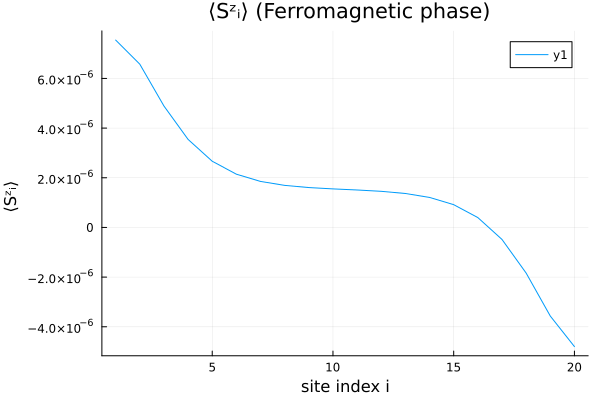

In [1120]:
plot(Sz_exp_vals_ferro,title=" ⟨Sᶻᵢ⟩ ($phase phase)",xlabel="site index i", ylabel="⟨Sᶻᵢ⟩ ")

The result obtained is a very small expectation value at each site, partically zero. Which is what I expected as a field in the x direction shouldn't cause a preference for either spin in the z direction. I assume the non-zero (but close) value is because of numerical artifects and the fact that the ground state is only approximated.

### b.

Calculating the correlations Sz1Szi as a function of i

In [952]:
SzSz_corr_array_ferro = [ expactation_O1i_O2j(psi_mps_ferro,Sz,1,Sz,i) for i in 2:L];
#SzSz_corr_array_ferro = CorrelationsByLength(psi_mps_ferro,Sz)

Plotting as a function of i

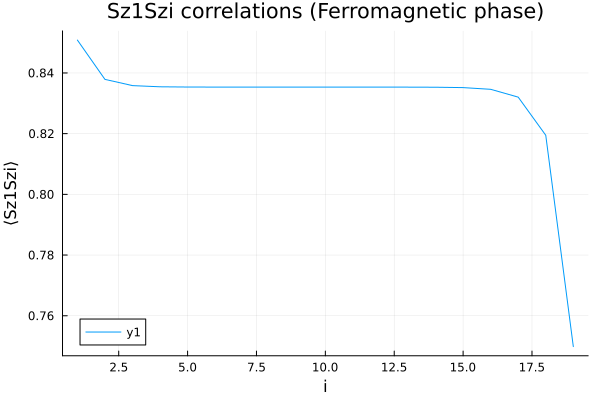

In [953]:
plot(SzSz_corr_array_ferro,title="Sz1Szi correlations ($phase phase)", xlabel="i",ylabel="⟨Sz1Szi⟩")

The correlation is about constant for all i, and its value is around the value of 0.835.

### c.

In [876]:
h=0.5
beta=10
dt=0.1
maxM=20;
L_array=[l for l in range(10,100,step=20)]
psi_mps_array_ferro= [find_ground_state_using_iTEBD(L, h , beta, dt, maxM) for L in L_array];

psi_mps.oc = 1
psi_mps.maxM = -1
Energy after imaginary time step 10 is -8.707150665037092
Energy after imaginary time step 20 is -9.655943842397877
Energy after imaginary time step 30 is -9.753144998840805
Energy after imaginary time step 40 is -9.764159385463017
Energy after imaginary time step 50 is -9.765357371590136
Energy after imaginary time step 60 is -9.765487616969697
Energy after imaginary time step 70 is -9.765501932330267
Energy after imaginary time step 80 is -9.765503555241326
Energy after imaginary time step 90 is -9.765503755075045
Energy after imaginary time step 100 is -9.76550378464199
psi_mps.oc = 1
psi_mps.maxM = -1
Energy after imaginary time step 10 is -27.426158772553645
Energy after imaginary time step 20 is -30.566744209280706
Energy after imaginary time step 30 is -30.963934366459668
Energy after imaginary time step 40 is -31.025999992098576
Energy after imaginary time step 50 is -31.034389344240893
Energy after imaginary time step 60 is -31.03549364652648
E

In [877]:
SVN_array_ferro= [calc_SVN_for_mps_at_bond(psi_mps,div(L,2)) for (psi_mps,L) in zip(psi_mps_array_ferro,L_array) ];

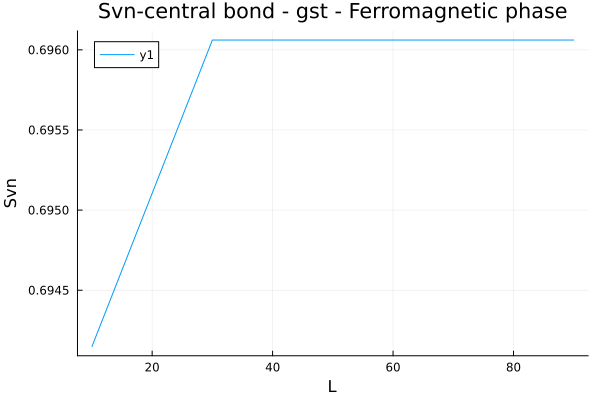

In [878]:
plot(L_array,SVN_array_ferro,title="Svn-central bond - gst - $phase phase",xlabel="L",ylabel="Svn")

We can see here that the entropy of the ground state across the central bond is practicly constant (even at small sizes, the entropy is comperable to that of larger sizes) and about ln2, as we expect from the ground state entropy across a partition being proportional to the boundary of the partition, in the 1D case - a constant for all system sizes.

## 2.2 Paramagnetic phase

In [880]:
L=50
h=1.5
beta=10
dt=0.1
maxM=20
phase="Paramagnetic";

Calculating the ground state using iTEBD

In [881]:
psi_mps_para=find_ground_state_using_iTEBD(L, h , beta, dt, maxM);

psi_mps.oc = 1
psi_mps.maxM = -1
Energy after imaginary time step 10 is -83.3755672017975
Energy after imaginary time step 20 is -83.41204801863819
Energy after imaginary time step 30 is -83.41223652342833
Energy after imaginary time step 40 is -83.41224494362724
Energy after imaginary time step 50 is -83.41224557621493
Energy after imaginary time step 60 is -83.41224563301128
Energy after imaginary time step 70 is -83.4122456385745
Energy after imaginary time step 80 is -83.41224563915043
Energy after imaginary time step 90 is -83.4122456392119
Energy after imaginary time step 100 is -83.41224563921891


### a.

Calculating the local expectation value of Sx along the chain for the ground state obtained:

In [882]:
Sx_exp_vals_para=ExpectationValue(psi_mps_para, Sx);

Plotting the expectation value along the chain

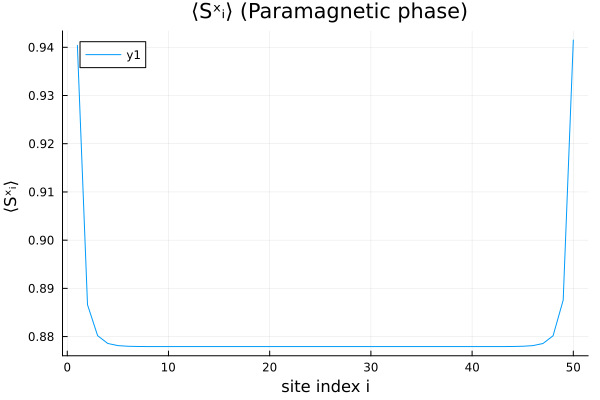

In [883]:
plot(Sx_exp_vals_para,title=" ⟨Sˣᵢ⟩ ($phase phase)",xlabel="site index i", ylabel="⟨Sˣᵢ⟩ ")

The spins are arranged mostly in the x direction when a strong(er) field is applied as expected. If h would have increased even more, the expectation will be closer to 1.

A simple check in the following blocks:

In [892]:
L=50
h=10.
beta=10
dt=0.1
maxM=20
phase="Paramagnetic"
psi_mps_para_deeper=find_ground_state_using_iTEBD(L, h , beta, dt, maxM)
Sx_exp_vals_para_deeper=ExpectationValue(psi_mps_para_deeper, Sx);

psi_mps.oc = 1
psi_mps.maxM = -1
Energy after imaginary time step 10 is -501.2090871978411
Energy after imaginary time step 20 is -501.2090871978472
Energy after imaginary time step 30 is -501.2090871978465
Energy after imaginary time step 40 is -501.20908719784705
Energy after imaginary time step 50 is -501.2090871978466
Energy after imaginary time step 60 is -501.209087197846
Energy after imaginary time step 70 is -501.20908719784745
Energy after imaginary time step 80 is -501.2090871978452
Energy after imaginary time step 90 is -501.20908719784643
Energy after imaginary time step 100 is -501.209087197847


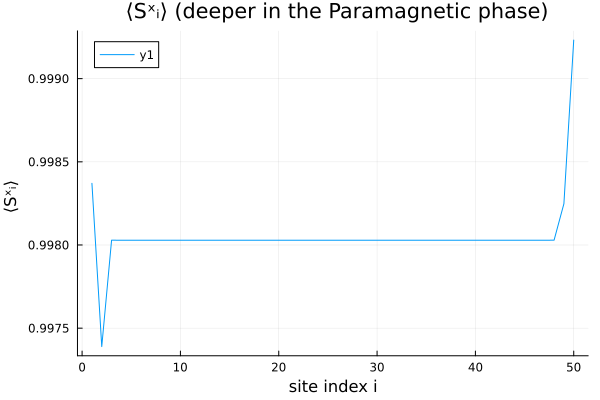

In [893]:
plot(Sx_exp_vals_para_deeper,title=" ⟨Sˣᵢ⟩ (deeper in the $phase phase)",xlabel="site index i", ylabel="⟨Sˣᵢ⟩ ")

### b. 

In [894]:
h=1.5
beta=10
dt=0.1
maxM=20;
L_array=[l for l in range(10,100,step=20)]
psi_mps_array_para= [find_ground_state_using_iTEBD(L, h , beta, dt, maxM) for L in L_array];

psi_mps.oc = 1
psi_mps.maxM = -1
Energy after imaginary time step 10 is -16.52466014190813
Energy after imaginary time step 20 is -16.535137716706913
Energy after imaginary time step 30 is -16.5352347118388
Energy after imaginary time step 40 is -16.535238331359317
Energy after imaginary time step 50 is -16.535238484625502
Energy after imaginary time step 60 is -16.535238491303478
Energy after imaginary time step 70 is -16.535238491601344
Energy after imaginary time step 80 is -16.535238491615047
Energy after imaginary time step 90 is -16.535238491615655
Energy after imaginary time step 100 is -16.53523849161569
psi_mps.oc = 1
psi_mps.maxM = -1
Energy after imaginary time step 10 is -49.95012796461009
Energy after imaginary time step 20 is -49.973588283587056
Energy after imaginary time step 30 is -49.97373431538211
Energy after imaginary time step 40 is -49.97374128540565
Energy after imaginary time step 50 is -49.97374180960688
Energy after imaginary time step 60 is -49.9737418561660

In [895]:
SVN_array_para= [calc_SVN_for_mps_at_bond(psi_mps,div(L,2)) for (psi_mps,L) in zip(psi_mps_array_para,L_array) ];

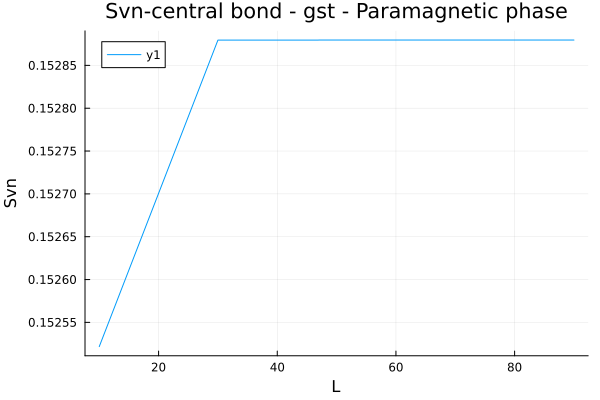

In [896]:
plot(L_array,SVN_array_para,title="Svn-central bond - gst - $phase phase",xlabel="L",ylabel="Svn")

Again the entropy across the central bond is constant, as we expect from a 1D system at its ground state - proportional to the boundary in our case is constant in respect to the system size.

## 2.3 Critical point

In [897]:
L=60
h=1.
beta=100
dt=0.1
maxM=20;
phase = "Critical point";

In [898]:
psi_mps=find_ground_state_using_iTEBD(L, h , beta, dt, maxM);

psi_mps.oc = 1
psi_mps.maxM = -1
Energy after imaginary time step 10 is -75.2523965092605
Energy after imaginary time step 20 is -75.91991644786184
Energy after imaginary time step 30 is -75.99166835440172
Energy after imaginary time step 40 is -76.0135511909749
Energy after imaginary time step 50 is -76.0226050472467
Energy after imaginary time step 60 is -76.02702469917726
Energy after imaginary time step 70 is -76.02941444458062
Energy after imaginary time step 80 is -76.03079658285306
Energy after imaginary time step 90 is -76.03163333519552
Energy after imaginary time step 100 is -76.03215612089646
Energy after imaginary time step 110 is -76.03249000604293
Energy after imaginary time step 120 is -76.03270660208312
Energy after imaginary time step 130 is -76.0328487263882
Energy after imaginary time step 140 is -76.03294280709447
Energy after imaginary time step 150 is -76.03300553542887
Energy after imaginary time step 160 is -76.03304762771823
Energy after imaginary time step 170

In [899]:
h=1.
beta=100
dt=0.1
maxM=20;
L_array=[l for l in range(10,100,step=10)]
psi_mps_array_critical= [find_ground_state_using_iTEBD(L, h , beta, dt, maxM) for L in L_array];

psi_mps.oc = 1
psi_mps.maxM = -1
Energy after imaginary time step 10 is -12.275630238640598
Energy after imaginary time step 20 is -12.376037396083952
Energy after imaginary time step 30 is -12.380873302250487
Energy after imaginary time step 40 is -12.381405366697523
Energy after imaginary time step 50 is -12.38147385891322
Energy after imaginary time step 60 is -12.38148399482702
Energy after imaginary time step 70 is -12.381485730866272
Energy after imaginary time step 80 is -12.381486074065505
Energy after imaginary time step 90 is -12.381486151227241
Energy after imaginary time step 100 is -12.381486170479668
Energy after imaginary time step 110 is -12.381486175662022
Energy after imaginary time step 120 is -12.38148617712922
Energy after imaginary time step 130 is -12.381486177557825
Energy after imaginary time step 140 is -12.38148617768537
Energy after imaginary time step 150 is -12.38148617772377
Energy after imaginary time step 160 is -12.381486177735358
Energy after imaginar

Energy after imaginary time step 710 is -25.107791027322047
Energy after imaginary time step 720 is -25.107791027322012
Energy after imaginary time step 730 is -25.107791027322058
Energy after imaginary time step 740 is -25.107791027322115
Energy after imaginary time step 750 is -25.107791027322065
Energy after imaginary time step 760 is -25.107791027322126
Energy after imaginary time step 770 is -25.107791027322108
Energy after imaginary time step 780 is -25.107791027322072
Energy after imaginary time step 790 is -25.10779102732206
Energy after imaginary time step 800 is -25.107791027322097
Energy after imaginary time step 810 is -25.107791027322055
Energy after imaginary time step 820 is -25.107791027322083
Energy after imaginary time step 830 is -25.107791027322136
Energy after imaginary time step 840 is -25.107791027322087
Energy after imaginary time step 850 is -25.10779102732202
Energy after imaginary time step 860 is -25.107791027322108
Energy after imaginary time step 870 is -2

Energy after imaginary time step 430 is -50.569422884524194
Energy after imaginary time step 440 is -50.56942288476998
Energy after imaginary time step 450 is -50.569422884950335
Energy after imaginary time step 460 is -50.56942288508211
Energy after imaginary time step 470 is -50.56942288517907
Energy after imaginary time step 480 is -50.569422885250006
Energy after imaginary time step 490 is -50.56942288530186
Energy after imaginary time step 500 is -50.56942288534042
Energy after imaginary time step 510 is -50.56942288536802
Energy after imaginary time step 520 is -50.569422885388626
Energy after imaginary time step 530 is -50.56942288540393
Energy after imaginary time step 540 is -50.56942288541482
Energy after imaginary time step 550 is -50.56942288542267
Energy after imaginary time step 560 is -50.569422885428665
Energy after imaginary time step 570 is -50.56942288543322
Energy after imaginary time step 580 is -50.56942288543621
Energy after imaginary time step 590 is -50.5694228

Energy after imaginary time step 160 is -76.03304762771823
Energy after imaginary time step 170 is -76.03307604569969
Energy after imaginary time step 180 is -76.03309535099147
Energy after imaginary time step 190 is -76.03310855202696
Energy after imaginary time step 200 is -76.03311764325233
Energy after imaginary time step 210 is -76.03312395284314
Energy after imaginary time step 220 is -76.0331283690047
Energy after imaginary time step 230 is -76.03313148823193
Energy after imaginary time step 240 is -76.03313371291371
Energy after imaginary time step 250 is -76.03313531583491
Energy after imaginary time step 260 is -76.03313648294103
Energy after imaginary time step 270 is -76.03313734176567
Energy after imaginary time step 280 is -76.03313798038795
Energy after imaginary time step 290 is -76.0331384601122
Energy after imaginary time step 300 is -76.03313882396469
Energy after imaginary time step 310 is -76.03313910242747
Energy after imaginary time step 320 is -76.03313931730213

Energy after imaginary time step 900 is -88.76522604395741
Energy after imaginary time step 910 is -88.7652260439671
Energy after imaginary time step 920 is -88.76522604397492
Energy after imaginary time step 930 is -88.76522604398119
Energy after imaginary time step 940 is -88.76522604398613
Energy after imaginary time step 950 is -88.76522604399052
Energy after imaginary time step 960 is -88.7652260439949
Energy after imaginary time step 970 is -88.7652260439984
Energy after imaginary time step 980 is -88.76522604400067
Energy after imaginary time step 990 is -88.76522604400294
Energy after imaginary time step 1000 is -88.76522604400492
psi_mps.oc = 1
psi_mps.maxM = -1
Energy after imaginary time step 10 is -100.44254752405328
Energy after imaginary time step 20 is -101.33744228466814
Energy after imaginary time step 30 is -101.43637696642114
Energy after imaginary time step 40 is -101.46727428042138
Energy after imaginary time step 50 is -101.4803905635539
Energy after imaginary tim

Energy after imaginary time step 610 is -114.22960113340628
Energy after imaginary time step 620 is -114.229601148146
Energy after imaginary time step 630 is -114.22960116092823
Energy after imaginary time step 640 is -114.22960117201454
Energy after imaginary time step 650 is -114.2296011816352
Energy after imaginary time step 660 is -114.22960118998499
Energy after imaginary time step 670 is -114.22960119723763
Energy after imaginary time step 680 is -114.22960120353548
Energy after imaginary time step 690 is -114.22960120900674
Energy after imaginary time step 700 is -114.22960121376104
Energy after imaginary time step 710 is -114.22960121789208
Energy after imaginary time step 720 is -114.22960122148292
Energy after imaginary time step 730 is -114.22960122460455
Energy after imaginary time step 740 is -114.22960122731804
Energy after imaginary time step 750 is -114.2296012296775
Energy after imaginary time step 760 is -114.2296012317288
Energy after imaginary time step 770 is -114.

In [900]:
SVN_array_critical= [calc_SVN_for_mps_at_bond(psi_mps,div(L,2)) for (psi_mps,L) in zip(psi_mps_array_critical,L_array) ];

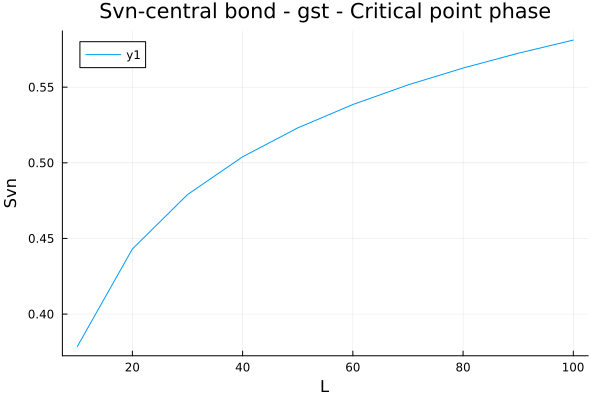

In [901]:
plot(L_array,SVN_array_critical,title="Svn-central bond - gst - $phase phase",xlabel="L",ylabel="Svn")

In [902]:
# Define your model function
model(x, p) = p[1]*log.(x) .+ p[2]


# Fit the model to the data
p0 = [0.08, 0.0] # Initial guess for the parameters
fit = curve_fit(model, L_array, SVN_array_critical, p0)

# fit.param will contain the fitted parameters
println("Fitted parameters: ", fit.param)
c=fit.param[1]*6;

Fitted parameters: [0.087558181917009, 0.1795279089504667]


In [903]:
println("By the fit calculated, the central charge c=$c ")

By the fit calculated, the central charge c=0.525349091502054 


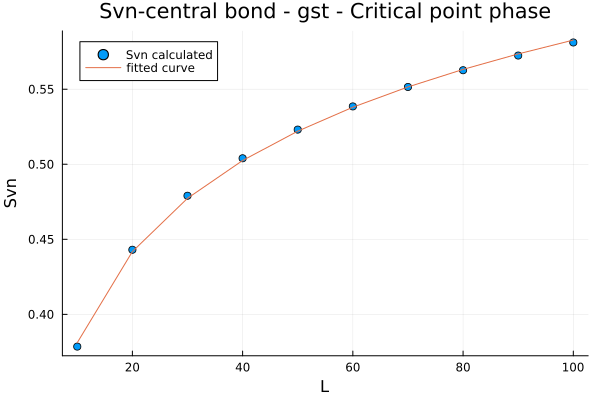

In [904]:
scatter(L_array,SVN_array_critical,title="Svn-central bond - gst - $phase phase",xlabel="L",ylabel="Svn",label="Svn calculated")
plot!(L_array,model(L_array,fit.param), label="fitted curve")

In [905]:
# Generate predicted y-values
y_pred = model(L_array, fit.param)

# Calculate residuals
residuals = SVN_array_critical - y_pred

# Then you can
# calculate SSR, R², etc. using these residuals
ssr = sum(abs2, residuals)
y_mean = mean(SVN_array)
ss_tot = sum((SVN_array .- y_mean).^2)
r_squared = 1 - ssr/ss_tot
println("By the fit calculated: ssr = $ssr, R^2 = $r_squared")

By the fit calculated: ssr = 1.8759826484496795e-5, R^2 = 0.9970423499884428


The central charge obtained is approximatly 0.52, which is pretty close to 1/2.

# 3. AKLT model

For a system of size L=10

In [965]:
L=10;

### 1.

Preparing the 4 states

In [1110]:
function psi_gs_aklt(L::Int64, gs_index::Int64)
    """
    Input:
    L- length of the chain
    gs_index- index of the ground state, needs to be between an integer between 0 and 3
    
    Output:
    An MPS representation of the to be proven to be ground states of the aklt
    """
    A⁺=[0 √(2/3) ; 0 0]
    A⁰=[-1/√3 0 ; 0 1/√3]
    A⁻=[0 0; -√(2/3) 0]
    A=zeros(Float64, 2, 3, 2)
    A[:,1,:]= A⁺
    A[:,2,:]= A⁰
    A[:,3,:]= A⁻;
    
    i=Int64(gs_index%2)
    j=Int64(div(gs_index,2))
    
    psi = Array{Float64}[]
    #Vector{Array{Float64}}
    
    push!(psi,reshape(deepcopy(A[i+1,:,:]),(1,3,2)))
    
    for i in 2:L-1
        push!(psi,reshape(deepcopy(A),(2,3,2)))
    end
    push!(psi,reshape(deepcopy(A[:,:,j+1]),(2,3,1)))
    NormalizePsi!(psi)
    return MPSrep(psi)
    
end;

In [1096]:
psi_gs_aklt_states=[psi_gs_aklt(10,i) for i in 0:3];

Consturcting the bond Hamiltonian (in the form of (12) from rec 4, up to that constant):

$H_{AKLT}=\sum_{i}\frac{1}{12}\vec{S}_{i,i+1}^{2}(\vec{S}_{i,i+1}^{2}-2)$


$H_{bond}=\frac{1}{12}\vec{S}_{i,i+1}^{2}(\vec{S}_{i,i+1}^{2}-2)$

In [1108]:
function BondH_AKLT()
    S_x = (1/√2)*[0 1 0 ; 1 0 1 ; 0 1 0 ]
    S_y = (-im/√2)*[0 1 0 ; -1 0 1 ; 0 -1 0 ]
    S_z = [1 0 0 ; 0 0 0 ; 0 0 -1]
    Id3 = Matrix{Complex{Float64}}(I, 3, 3)
    Id9 = Matrix{Complex{Float64}}(I, 9, 9)
    S_vec_i = [ kron(S_x,Id3) , kron(S_y,Id3) , kron(S_z,Id3)]
    S_vec_ip1= [ kron(Id3,S_x) , kron(Id3,S_y) , kron(Id3,S_z)]
    S_tot= S_vec_i+S_vec_ip1
    S_tot_squared=S_tot[1]*S_tot[1]+S_tot[2]*S_tot[2]+S_tot[3]*S_tot[3]
    #construct hamiltonian up to that constant
    Hb = (1/12)*(S_tot_squared*(S_tot_squared-(2*Id9)))
    return Hb
end;

In [1098]:
function CalculateEnergy_AKLT(psi::Vector{Array{Float64}})
    L = length(psi)
    
    Etot = 0.

    for i in range(1, stop=L-1)
        
        # Generate the Hamiltonian matrix for the two-site bond
        Hb = reshape(BondH_AKLT(), (3, 3, 3, 3))
        
        # Calculate the bond tensor for the current bond
        psi_bond = BondTensor(psi, i)
        
        # Initialize a tensor for H * psi
        H_psi = zeros(size(psi_bond))
        
        # Contract H with the current bond tensor to obtain H * psi
        @tensor H_psi[l0, s1p, s2p, l2] = Hb[s2p, s1p, s2, s1] * psi_bond[l0, s1, s2, l2]
        
        # Contract psi^† * H * psi to obtain the energy contribution
        @tensor psi_H_psi = psi_bond[l0, s1p, s2p, l2] * H_psi[l0, s1p, s2p, l2]
        
        # Accumulate the energy contribution
        Etot += psi_H_psi
        
        # Update the MPS by applying the new bond tensor with left canonical form (no truncation or renormalization)
        SvdBondTensor!(psi, i, psi_bond, true)
    end
    
    return Etot
end;

In [1105]:
CalculateEnergy_AKLT_arr=[CalculateEnergy_AKLT(deepcopy(psi.state)) for psi in psi_gs_aklt_states];

In [1107]:
CalculateEnergy_AKLT_arr;

In [1109]:
println("The energies calculated for the 4 states are: $CalculateEnergy_AKLT_arr")

The energies calculated for the 4 states are: [-2.4760725461296802e-17, 1.0685658653649503e-17, 1.3296867428804347e-17, 1.1838263205943489e-17]


Paracticly zero energy for all of the states, which means the 4 states are of the same subspace with the same energy. The Hamiltonian is non-negative thus these must also be ground states.

### 2. 

In [1113]:
S_z = [1 0 0 ; 0 0 0 ; 0 0 -1];

In [1140]:
expectation_Sz_arr = [ExpectationValue(psi_mps, S_z) for psi_mps in psi_gs_aklt_states ];

In [1196]:
function plot_and_talk_about_Sz_expectation(expectation_Sz,gst_index,gst_name)
    p=plot(expectation_Sz_arr[gst_index],xlabel="i",ylabel="⟨Sz⟩",title="gst $gst_index $gst_name ⟨Sz⟩'s across the chain")
    left=expectation_Sz_arr[gst_index][1]
    right=expectation_Sz_arr[gst_index][end]
    sum_5_left=sum([expectation_Sz_arr[gst_index][i] for i in 1:5])
    sum_5_right=sum([expectation_Sz_arr[gst_index][end-i+1] for i in 1:5])
    println("For gst $gst_index:")
    println("The spin values at the edges are- Left=$left Right=$right")
    println("The spin sum of 5 nearest to the edges are- Left=$sum_5_left Right=$sum_5_right")
    return p
end;

For gst 1:
The spin values at the edges are- Left=0.6666892464013543 Right=-0.666689246401355
The spin sum of 5 nearest to the edges are- Left=0.5041151566469093 Right=-0.5041151566469101


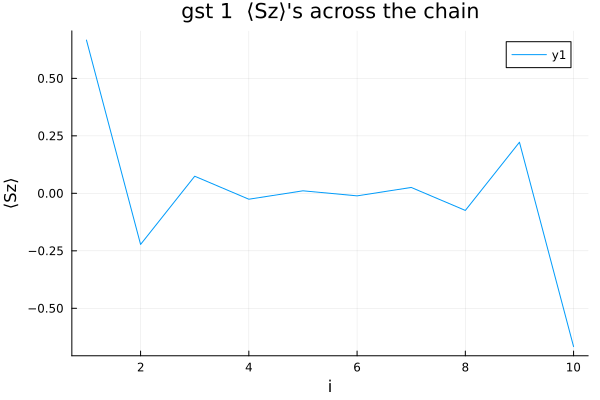

In [1204]:
plot_and_talk_about_Sz_expectation(expectation_Sz_arr[1],1,"")

For gst 2:
The spin values at the edges are- Left=-0.6666440861671852 Right=-0.6666440861671846
The spin sum of 5 nearest to the edges are- Left=-0.5000000000000003 Right=-0.4999999999999982


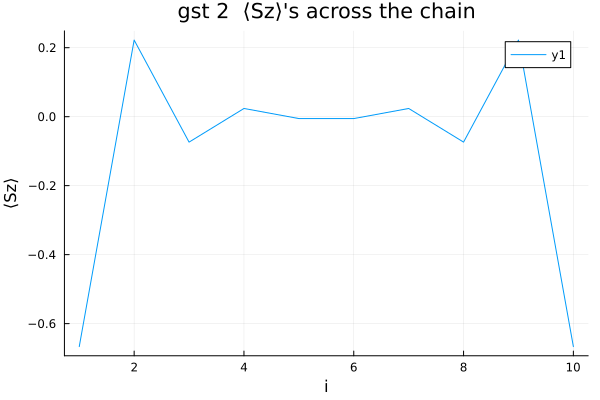

In [1203]:
plot_and_talk_about_Sz_expectation(expectation_Sz_arr[2],2,"")

For gst 3:
The spin values at the edges are- Left=0.6666440861671856 Right=0.6666440861671868
The spin sum of 5 nearest to the edges are- Left=0.5000000000000001 Right=0.5000000000000002


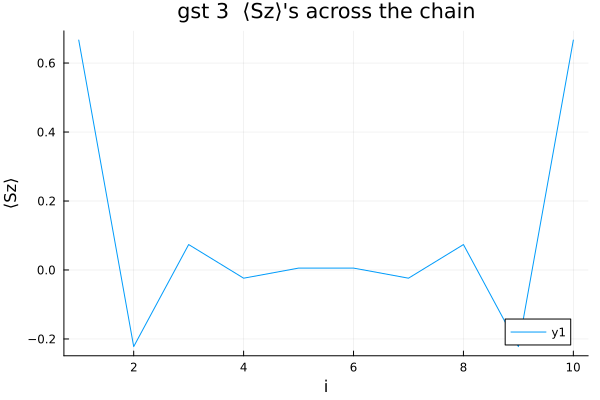

In [1199]:
plot_and_talk_about_Sz_expectation(expectation_Sz_arr[3],3,"")

For gst 4:
The spin values at the edges are- Left=-0.666689246401355 Right=0.6666892464013559
The spin sum of 5 nearest to the edges are- Left=-0.5041151566469093 Right=0.5041151566469096


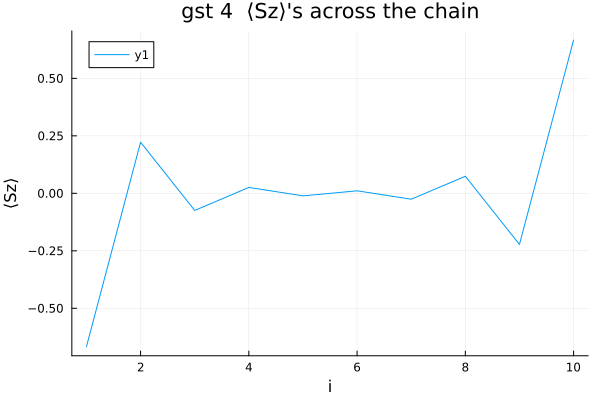

In [1201]:
plot_and_talk_about_Sz_expectation(expectation_Sz_arr[4],4,"")

The spin values at the edges is found to be of absolute value of 2/3 in all 4 cases. If I sum over the spins up untill the middle of the chain (5 spins from each side) the sum is gets really close to 1/2 in all cases.

Unused functions

In [58]:
# Based on BondH From Recitation 5
#=
function BondH(h::Float64)
    """
    BondH(h1::Float64, h2::Float64)

    Generate the bond Hamiltonian matrix for a two-site bond in the Transverse Field Ising Model (TFIM).

    # Arguments
    - `h1`: Coefficient for the Sx⨂Id term.
    - `h2`: Coefficient for the Id⨂Sx term.

    # Returns
    The Hamiltonian matrix for the two-site bond in the TFIM.

    """
    # Pauli matrices
    Sx = [0.0 1.0; 1.0 0.0]
    Sz = [1.0 0.0; 0.0 -1.0]
    Id = [1.0 0.0; 0.0 1.0]

    # Construct the Hamiltonian matrix for the two-site bond in the TFIM
    Hb = -kron(Sz, Sz) + h*(kron(Sx, Id) + kron(Id, Sx))
    
    return Hb
end;
function ∏ₙᴸIₙ(L)
    if L==0
        return 1
    end
    Id=[1.0 0.0; 0.0 1.0]
    Id_temp= Id
    #Id_arr= [Id]
    for i in 1:L-1
        #push!(Id_arr,last(Id_arr)⊗Id)
        Id_temp = Id_temp⊗Id
    end
    return Id_temp
end;
function O_exp(psi::Vector{Array{Float64}},O_array)
    """
    O_array is a tuple (i,O) - when i is the index of the site and O is the operator to be applied on the site
    """
    
    L = length(psi)
    
    Exp_tot = 0.

    for (i,O) in O_array
        
        # Initialize a tensor for O*psi
        O_psi = zeros(size(psi[i]))
        
        # Contract O with the current site tensor to obtain O * psi
        @tensor O_psi[l0, sp, l2] = O[sp,s] * psi[i][l0,s, l2]
        
        # Contract psi^† * H * psi to obtain the energy contribution
        @tensor psi_O_psi = psi[i][l0, sp, l2] * O_psi[l0, sp, l2]
        
        # Accumulate the energy contribution
        Exp_tot += psi_O_psi
    end
    
    return Etot
end;
function local_O_expectation!(psi_mps,O,i)
    OrthogonalizePsi!(psi_mps, i)
    Ai=psi_mps.state[i]
    M0=size(Ai)[1]
    M1=size(Ai)[3]
    #contract with the ith site tensor
    # Initialize tensors for Ai * O
    Ai_O = zeros(M0, 2, M1)
    @tensor Ai_O[l0, sp, l1] = Ai[l0, s, l1] * O[s, sp]

    # Calculate Ai * O * Ai'
    Ai_O_Aip = zeros(M1, M1)
    @tensor Ai_O_Aip[l1, l1p] = Ai_O[l0, sp, l1] * Ai[l0, sp, l1p]
end;
=#